In [1]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import STM32FProgrammer
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_glitch'))
hex_file = os.path.join(firmware_dir, r'simple_glitch-CW308_STM32F0.hex')
print(firmware_dir)

/usr/local/lib/python3.6/dist-packages/hardware/victims/firmware/simple_glitch


In [2]:
firmware_dir = '/home/wwa/data/cw/chipwhisperer/hardware/victims/firmware/simple_glitch/'
hex_file = os.path.join(firmware_dir, r'simple_glitch-CW308_STM32F0.hex')

In [3]:
#from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
#Resetter = ResetCW1173(pin='pdic', delay_ms=1)

In [4]:
# Notebook settings
%matplotlib notebook

In [5]:
scope = cw.scope()
target = cw.target(scope)

In [6]:
scope.gain.gain = 45
scope.adc.samples = 450
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"

In [7]:
programmer = STM32FProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.open()
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

Detected known STMF32: STM32F071xx/STM32F072xx
Extended erase (0x44), this can take ten seconds or more
Attempting to programming 4175 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4175 bytes


In [8]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def reset(scope):
    scope.io.nrst='low'
    time.sleep(0.010)
    scope.io.nrst='high'
    time.sleep(0.025)
def runone(x,y,r=5):
    while r != 0:
        target.reinit()
        scope.arm()
        #target.getConnection().hardware_write(x)
        #target.getConnection().hardware_write(y)
        timeout = 50
        while target.isDone() is False and timeout > 0:
            timeout -= 1
            time.sleep(0.01)
        out = ""
        out = target.getConnection().hardware_read(1000)
        rst = scope.capture()
        if(not rst):
            return (scope.getLastTrace(),out)
        reset(scope)
        r -= 1
    return ()
def hexdump(x):
    return ":".join("{:02x}".format(ord(c)) for c in x)
def glitch_setup(eoff,rep,off,wid):
    scope.io.hs2             = "glitch"
    scope.glitch.clk_src     = 'clkgen'
    scope.glitch.trigger_src = 'ext_single'
    scope.glitch.arm_timing  = 'after_scope'
    scope.glitch.output      = 'clock_xor'
    scope.glitch.ext_offset  = eoff
    scope.glitch.repeat      = rep
    scope.glitch.offset      = off
    scope.glitch.offset_fine = 0
    scope.glitch.width       = wid
    scope.glitch.width_fine  = 0

<IPython.core.display.Javascript object>


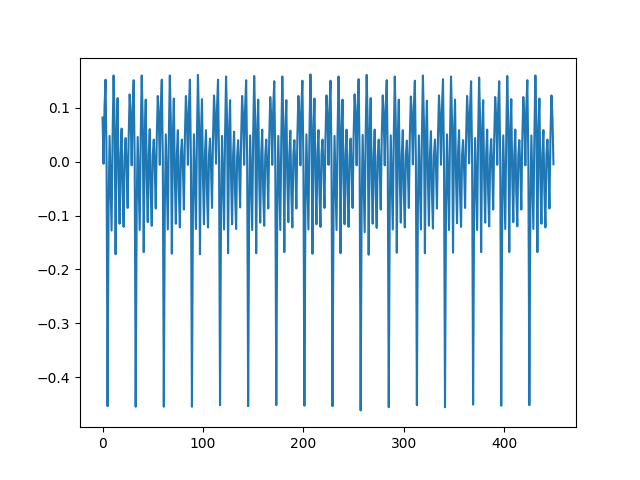

[25, 8, 8, 32, 32, 0, 0, 104, 101, 108, 111]


In [9]:
glitch_setup(1,1,1,1)
(trc,out) = runone(b'baaaaaaa',b'aaaaaaaa')
plot((trc,))
print(out)

<IPython.core.display.Javascript object>


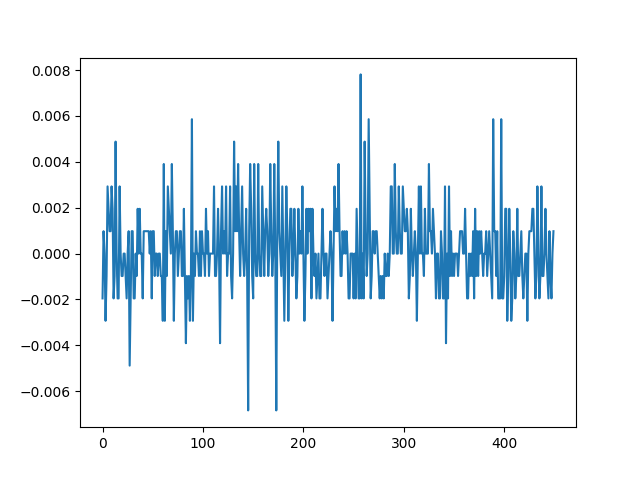

[]


In [10]:
glitch_setup(20,1,5,5)
(x,out) = runone(b'baaaaaaa',b'aaaaaaaa')
plot((x-trc,))
print(out)

In [14]:
idx = 0
for ie in range(3):
    for io in range(10):
        for iw in range(10):
            e = ie+5
            r = 1
            o = 4+io/5
            w = 2+iw/10
            glitch_setup(e,r,o,w)
            try:
                # retry 5 times before reporting failure
                (trc,out) = runone('','',5)
            except ValueError as ioex:
                out = "[capture failed]"
                try:
                    # reset and try with "safe" params, make sure that works
                    glitch_setup(1,1,1,1)
                    runone('','',3)
                except ValueError as ioex2:
                    # "safe" params failed too, needs power cycle / reflash
                    raise Exception('Fatal, reset failed, cycle power')
            idx += 1
            print("i=",idx,"e=",e,"r=",r,"o=",o,"w=",w,":",out)

i= 1 e= 5 r= 1 o= 4.0 w= 2.0 : []
i= 2 e= 5 r= 1 o= 4.0 w= 2.1 : []
i= 3 e= 5 r= 1 o= 4.0 w= 2.2 : []
i= 4 e= 5 r= 1 o= 4.0 w= 2.3 : []
i= 5 e= 5 r= 1 o= 4.0 w= 2.4 : []
i= 6 e= 5 r= 1 o= 4.0 w= 2.5 : []
i= 7 e= 5 r= 1 o= 4.0 w= 2.6 : []


i= 8 e= 5 r= 1 o= 4.0 w= 2.7 : [74, 40, 8, 0, 104, 101, 108, 111]


i= 9 e= 5 r= 1 o= 4.0 w= 2.8 : [58, 32, 40, 0, 1, 0, 0, 104, 101, 108, 111]
i= 10 e= 5 r= 1 o= 4.0 w= 2.9 : []


i= 11 e= 5 r= 1 o= 4.2 w= 2.0 : [43, 0, 0, 104, 101, 108, 111]
i= 12 e= 5 r= 1 o= 4.2 w= 2.1 : []
i= 13 e= 5 r= 1 o= 4.2 w= 2.2 : []
i= 14 e= 5 r= 1 o= 4.2 w= 2.3 : []
i= 15 e= 5 r= 1 o= 4.2 w= 2.4 : []
i= 16 e= 5 r= 1 o= 4.2 w= 2.5 : []
i= 17 e= 5 r= 1 o= 4.2 w= 2.6 : []


i= 18 e= 5 r= 1 o= 4.2 w= 2.7 : [58, 8, 0, 104, 101, 108, 111]
i= 19 e= 5 r= 1 o= 4.2 w= 2.8 : []


i= 20 e= 5 r= 1 o= 4.2 w= 2.9 : [capture failed]
i= 21 e= 5 r= 1 o= 4.4 w= 2.0 : []
i= 22 e= 5 r= 1 o= 4.4 w= 2.1 : []
i= 23 e= 5 r= 1 o= 4.4 w= 2.2 : []
i= 24 e= 5 r= 1 o= 4.4 w= 2.3 : []
i= 25 e= 5 r= 1 o= 4.4 w= 2.4 : []
i= 26 e= 5 r= 1 o= 4.4 w= 2.5 : []
i= 27 e= 5 r= 1 o= 4.4 w= 2.6 : []


i= 28 e= 5 r= 1 o= 4.4 w= 2.7 : [34, 32, 0, 0, 104, 101, 108, 111]


i= 29 e= 5 r= 1 o= 4.4 w= 2.8 : [58, 32, 32, 0, 1, 104, 101, 108, 111]
i= 30 e= 5 r= 1 o= 4.4 w= 2.9 : []


i= 31 e= 5 r= 1 o= 4.6 w= 2.0 : [50, 0, 40, 0, 0, 104, 101, 108, 111]
i= 32 e= 5 r= 1 o= 4.6 w= 2.1 : []
i= 33 e= 5 r= 1 o= 4.6 w= 2.2 : []
i= 34 e= 5 r= 1 o= 4.6 w= 2.3 : []
i= 35 e= 5 r= 1 o= 4.6 w= 2.4 : []
i= 36 e= 5 r= 1 o= 4.6 w= 2.5 : []
i= 37 e= 5 r= 1 o= 4.6 w= 2.6 : []


i= 38 e= 5 r= 1 o= 4.6 w= 2.7 : [capture failed]
i= 39 e= 5 r= 1 o= 4.6 w= 2.8 : []


i= 40 e= 5 r= 1 o= 4.6 w= 2.9 : [capture failed]
i= 41 e= 5 r= 1 o= 4.8 w= 2.0 : []
i= 42 e= 5 r= 1 o= 4.8 w= 2.1 : []
i= 43 e= 5 r= 1 o= 4.8 w= 2.2 : []
i= 44 e= 5 r= 1 o= 4.8 w= 2.3 : []
i= 45 e= 5 r= 1 o= 4.8 w= 2.4 : []
i= 46 e= 5 r= 1 o= 4.8 w= 2.5 : []
i= 47 e= 5 r= 1 o= 4.8 w= 2.6 : []


i= 48 e= 5 r= 1 o= 4.8 w= 2.7 : [capture failed]
i= 49 e= 5 r= 1 o= 4.8 w= 2.8 : []


i= 50 e= 5 r= 1 o= 4.8 w= 2.9 : [capture failed]
i= 51 e= 5 r= 1 o= 5.0 w= 2.0 : []
i= 52 e= 5 r= 1 o= 5.0 w= 2.1 : []
i= 53 e= 5 r= 1 o= 5.0 w= 2.2 : []
i= 54 e= 5 r= 1 o= 5.0 w= 2.3 : []
i= 55 e= 5 r= 1 o= 5.0 w= 2.4 : []
i= 56 e= 5 r= 1 o= 5.0 w= 2.5 : []
i= 57 e= 5 r= 1 o= 5.0 w= 2.6 : []


i= 58 e= 5 r= 1 o= 5.0 w= 2.7 : [capture failed]
i= 59 e= 5 r= 1 o= 5.0 w= 2.8 : []


i= 60 e= 5 r= 1 o= 5.0 w= 2.9 : [capture failed]
i= 61 e= 5 r= 1 o= 5.2 w= 2.0 : []
i= 62 e= 5 r= 1 o= 5.2 w= 2.1 : []
i= 63 e= 5 r= 1 o= 5.2 w= 2.2 : []
i= 64 e= 5 r= 1 o= 5.2 w= 2.3 : []
i= 65 e= 5 r= 1 o= 5.2 w= 2.4 : []
i= 66 e= 5 r= 1 o= 5.2 w= 2.5 : []
i= 67 e= 5 r= 1 o= 5.2 w= 2.6 : []


i= 68 e= 5 r= 1 o= 5.2 w= 2.7 : [capture failed]
i= 69 e= 5 r= 1 o= 5.2 w= 2.8 : []


i= 70 e= 5 r= 1 o= 5.2 w= 2.9 : [capture failed]
i= 71 e= 5 r= 1 o= 5.4 w= 2.0 : []
i= 72 e= 5 r= 1 o= 5.4 w= 2.1 : []
i= 73 e= 5 r= 1 o= 5.4 w= 2.2 : []
i= 74 e= 5 r= 1 o= 5.4 w= 2.3 : []
i= 75 e= 5 r= 1 o= 5.4 w= 2.4 : []
i= 76 e= 5 r= 1 o= 5.4 w= 2.5 : []
i= 77 e= 5 r= 1 o= 5.4 w= 2.6 : []


i= 78 e= 5 r= 1 o= 5.4 w= 2.7 : [capture failed]
i= 79 e= 5 r= 1 o= 5.4 w= 2.8 : []


i= 80 e= 5 r= 1 o= 5.4 w= 2.9 : [capture failed]
i= 81 e= 5 r= 1 o= 5.6 w= 2.0 : []
i= 82 e= 5 r= 1 o= 5.6 w= 2.1 : []
i= 83 e= 5 r= 1 o= 5.6 w= 2.2 : []
i= 84 e= 5 r= 1 o= 5.6 w= 2.3 : []
i= 85 e= 5 r= 1 o= 5.6 w= 2.4 : []
i= 86 e= 5 r= 1 o= 5.6 w= 2.5 : []
i= 87 e= 5 r= 1 o= 5.6 w= 2.6 : []


i= 88 e= 5 r= 1 o= 5.6 w= 2.7 : [capture failed]
i= 89 e= 5 r= 1 o= 5.6 w= 2.8 : []


i= 90 e= 5 r= 1 o= 5.6 w= 2.9 : [capture failed]
i= 91 e= 5 r= 1 o= 5.8 w= 2.0 : []
i= 92 e= 5 r= 1 o= 5.8 w= 2.1 : []
i= 93 e= 5 r= 1 o= 5.8 w= 2.2 : []
i= 94 e= 5 r= 1 o= 5.8 w= 2.3 : []
i= 95 e= 5 r= 1 o= 5.8 w= 2.4 : []
i= 96 e= 5 r= 1 o= 5.8 w= 2.5 : []
i= 97 e= 5 r= 1 o= 5.8 w= 2.6 : []


i= 98 e= 5 r= 1 o= 5.8 w= 2.7 : [capture failed]
i= 99 e= 5 r= 1 o= 5.8 w= 2.8 : []


i= 100 e= 5 r= 1 o= 5.8 w= 2.9 : [capture failed]
i= 101 e= 6 r= 1 o= 4.0 w= 2.0 : []
i= 102 e= 6 r= 1 o= 4.0 w= 2.1 : []
i= 103 e= 6 r= 1 o= 4.0 w= 2.2 : []
i= 104 e= 6 r= 1 o= 4.0 w= 2.3 : []
i= 105 e= 6 r= 1 o= 4.0 w= 2.4 : []
i= 106 e= 6 r= 1 o= 4.0 w= 2.5 : []
i= 107 e= 6 r= 1 o= 4.0 w= 2.6 : [112, 97, 115, 115]


i= 108 e= 6 r= 1 o= 4.0 w= 2.7 : [34, 32, 0, 104, 101, 108, 111, 112, 97, 115, 115]


i= 109 e= 6 r= 1 o= 4.0 w= 2.8 : [178, 42, 40, 8, 0, 0, 104, 101, 108, 111]
i= 110 e= 6 r= 1 o= 4.0 w= 2.9 : [112, 97, 115, 115]


i= 111 e= 6 r= 1 o= 4.2 w= 2.0 : [178, 40, 0, 0, 0, 0, 104, 101, 108, 111]
i= 112 e= 6 r= 1 o= 4.2 w= 2.1 : []
i= 113 e= 6 r= 1 o= 4.2 w= 2.2 : []
i= 114 e= 6 r= 1 o= 4.2 w= 2.3 : []
i= 115 e= 6 r= 1 o= 4.2 w= 2.4 : []
i= 116 e= 6 r= 1 o= 4.2 w= 2.5 : []
i= 117 e= 6 r= 1 o= 4.2 w= 2.6 : [112, 97, 115, 115]


i= 118 e= 6 r= 1 o= 4.2 w= 2.7 : [42, 0, 0, 104, 101, 108, 111, 111]


i= 119 e= 6 r= 1 o= 4.2 w= 2.8 : [58, 32, 32, 8, 0, 0, 104, 101, 108, 111, 112, 97, 115, 115]


i= 120 e= 6 r= 1 o= 4.2 w= 2.9 : [58, 0, 0, 104, 101, 108, 111]


i= 121 e= 6 r= 1 o= 4.4 w= 2.0 : [8, 8, 104, 101, 108, 111]
i= 122 e= 6 r= 1 o= 4.4 w= 2.1 : []
i= 123 e= 6 r= 1 o= 4.4 w= 2.2 : []
i= 124 e= 6 r= 1 o= 4.4 w= 2.3 : []
i= 125 e= 6 r= 1 o= 4.4 w= 2.4 : []
i= 126 e= 6 r= 1 o= 4.4 w= 2.5 : []
i= 127 e= 6 r= 1 o= 4.4 w= 2.6 : [112, 97, 115, 115]


i= 128 e= 6 r= 1 o= 4.4 w= 2.7 : [58, 32, 32, 0, 0, 104, 101, 108, 111, 112, 97, 115, 115]


i= 129 e= 6 r= 1 o= 4.4 w= 2.8 : [58, 40, 0, 32, 0, 0, 104, 101, 108, 111, 112, 97, 115, 115]


i= 130 e= 6 r= 1 o= 4.4 w= 2.9 : [50, 0, 0, 1, 0, 104, 101, 108, 111, 111]


i= 131 e= 6 r= 1 o= 4.6 w= 2.0 : [186, 32, 32, 8, 0, 248, 104, 101, 108, 111]
i= 132 e= 6 r= 1 o= 4.6 w= 2.1 : []
i= 133 e= 6 r= 1 o= 4.6 w= 2.2 : []
i= 134 e= 6 r= 1 o= 4.6 w= 2.3 : []
i= 135 e= 6 r= 1 o= 4.6 w= 2.4 : []
i= 136 e= 6 r= 1 o= 4.6 w= 2.5 : []
i= 137 e= 6 r= 1 o= 4.6 w= 2.6 : [91]


i= 138 e= 6 r= 1 o= 4.6 w= 2.7 : [235, 58, 32, 32, 32, 1, 0, 104, 101, 108, 111, 91]


i= 139 e= 6 r= 1 o= 4.6 w= 2.8 : [186, 42, 32, 0, 0, 0, 104, 101, 108, 111, 111]


i= 140 e= 6 r= 1 o= 4.6 w= 2.9 : [50, 34, 32, 8, 0, 0, 0, 0, 33, 32, 32, 32, 32, 32, 32, 0, 9, 0, 0, 0, 104, 101, 108, 111, 91]


i= 141 e= 6 r= 1 o= 4.8 w= 2.0 : [42, 8, 0, 104, 101, 108, 111]
i= 142 e= 6 r= 1 o= 4.8 w= 2.1 : []
i= 143 e= 6 r= 1 o= 4.8 w= 2.2 : []
i= 144 e= 6 r= 1 o= 4.8 w= 2.3 : []
i= 145 e= 6 r= 1 o= 4.8 w= 2.4 : []
i= 146 e= 6 r= 1 o= 4.8 w= 2.5 : []
i= 147 e= 6 r= 1 o= 4.8 w= 2.6 : [112, 97, 115, 115]


i= 148 e= 6 r= 1 o= 4.8 w= 2.7 : [capture failed]
i= 149 e= 6 r= 1 o= 4.8 w= 2.8 : [112, 97, 115, 115]


i= 150 e= 6 r= 1 o= 4.8 w= 2.9 : [58, 32, 5, 104, 101, 108, 111]


i= 151 e= 6 r= 1 o= 5.0 w= 2.0 : [9, 1, 0, 104, 101, 108, 111]
i= 152 e= 6 r= 1 o= 5.0 w= 2.1 : []
i= 153 e= 6 r= 1 o= 5.0 w= 2.2 : []
i= 154 e= 6 r= 1 o= 5.0 w= 2.3 : []
i= 155 e= 6 r= 1 o= 5.0 w= 2.4 : []
i= 156 e= 6 r= 1 o= 5.0 w= 2.5 : []
i= 157 e= 6 r= 1 o= 5.0 w= 2.6 : [112, 97, 115, 115]


i= 158 e= 6 r= 1 o= 5.0 w= 2.7 : [153, 32, 32, 8, 0, 0, 104, 101, 108, 111, 91]


i= 159 e= 6 r= 1 o= 5.0 w= 2.8 : [235, 50, 32, 0, 0, 104, 101, 108, 111, 91]


i= 160 e= 6 r= 1 o= 5.0 w= 2.9 : [58, 32, 0, 0, 104, 101, 108, 111, 112, 97, 115, 115]


i= 161 e= 6 r= 1 o= 5.2 w= 2.0 : [42, 8, 0, 104, 101, 108, 111]
i= 162 e= 6 r= 1 o= 5.2 w= 2.1 : []
i= 163 e= 6 r= 1 o= 5.2 w= 2.2 : []
i= 164 e= 6 r= 1 o= 5.2 w= 2.3 : []
i= 165 e= 6 r= 1 o= 5.2 w= 2.4 : []
i= 166 e= 6 r= 1 o= 5.2 w= 2.5 : []
i= 167 e= 6 r= 1 o= 5.2 w= 2.6 : [91]


i= 168 e= 6 r= 1 o= 5.2 w= 2.7 : [32, 1, 104, 101, 108, 111, 91]


i= 169 e= 6 r= 1 o= 5.2 w= 2.8 : [42, 0, 0, 104, 101, 108, 111, 91]


i= 170 e= 6 r= 1 o= 5.2 w= 2.9 : [58, 40, 0, 0, 0, 0, 104, 101, 108, 111, 91]


i= 171 e= 6 r= 1 o= 5.4 w= 2.0 : [58, 40, 8, 0, 104, 101, 108, 111]
i= 172 e= 6 r= 1 o= 5.4 w= 2.1 : []
i= 173 e= 6 r= 1 o= 5.4 w= 2.2 : []
i= 174 e= 6 r= 1 o= 5.4 w= 2.3 : []
i= 175 e= 6 r= 1 o= 5.4 w= 2.4 : []
i= 176 e= 6 r= 1 o= 5.4 w= 2.5 : []
i= 177 e= 6 r= 1 o= 5.4 w= 2.6 : [112, 97, 115, 115]


i= 178 e= 6 r= 1 o= 5.4 w= 2.7 : [42, 8, 0, 104, 101, 108, 111, 91]


i= 179 e= 6 r= 1 o= 5.4 w= 2.8 : [139, 32, 1, 0, 0, 104, 101, 108, 111, 91]


i= 180 e= 6 r= 1 o= 5.4 w= 2.9 : [capture failed]
i= 181 e= 6 r= 1 o= 5.6 w= 2.0 : []
i= 182 e= 6 r= 1 o= 5.6 w= 2.1 : []
i= 183 e= 6 r= 1 o= 5.6 w= 2.2 : []
i= 184 e= 6 r= 1 o= 5.6 w= 2.3 : []
i= 185 e= 6 r= 1 o= 5.6 w= 2.4 : []
i= 186 e= 6 r= 1 o= 5.6 w= 2.5 : []
i= 187 e= 6 r= 1 o= 5.6 w= 2.6 : [91]


i= 188 e= 6 r= 1 o= 5.6 w= 2.7 : [34, 0, 0, 104, 101, 108, 111, 91]


i= 189 e= 6 r= 1 o= 5.6 w= 2.8 : [50, 32, 0, 0, 1, 0, 0, 104, 101, 108, 111, 91]


i= 190 e= 6 r= 1 o= 5.6 w= 2.9 : [2, 1, 0, 0, 104, 101, 108, 111, 91]


i= 191 e= 6 r= 1 o= 5.8 w= 2.0 : [250, 178, 2, 0, 32, 8, 0, 0, 0, 0, 4, 0, 0, 0, 32, 40, 40, 32, 32, 32, 224, 104, 101, 108, 111]
i= 192 e= 6 r= 1 o= 5.8 w= 2.1 : []
i= 193 e= 6 r= 1 o= 5.8 w= 2.2 : []
i= 194 e= 6 r= 1 o= 5.8 w= 2.3 : []
i= 195 e= 6 r= 1 o= 5.8 w= 2.4 : []
i= 196 e= 6 r= 1 o= 5.8 w= 2.5 : []
i= 197 e= 6 r= 1 o= 5.8 w= 2.6 : [111]


i= 198 e= 6 r= 1 o= 5.8 w= 2.7 : [50, 0, 0, 104, 101, 108, 111]


i= 199 e= 6 r= 1 o= 5.8 w= 2.8 : [58, 1, 1, 0, 0, 104, 101, 108, 111]


i= 200 e= 6 r= 1 o= 5.8 w= 2.9 : [235, 2, 33, 0, 32, 0, 104, 101, 108, 111]


i= 201 e= 7 r= 1 o= 4.0 w= 2.0 : [64, 249, 104, 101, 108, 111]
i= 202 e= 7 r= 1 o= 4.0 w= 2.1 : []
i= 203 e= 7 r= 1 o= 4.0 w= 2.2 : []
i= 204 e= 7 r= 1 o= 4.0 w= 2.3 : []
i= 205 e= 7 r= 1 o= 4.0 w= 2.4 : []
i= 206 e= 7 r= 1 o= 4.0 w= 2.5 : []
i= 207 e= 7 r= 1 o= 4.0 w= 2.6 : []
i= 208 e= 7 r= 1 o= 4.0 w= 2.7 : []
i= 209 e= 7 r= 1 o= 4.0 w= 2.8 : []
i= 210 e= 7 r= 1 o= 4.0 w= 2.9 : []
i= 211 e= 7 r= 1 o= 4.2 w= 2.0 : []
i= 212 e= 7 r= 1 o= 4.2 w= 2.1 : []
i= 213 e= 7 r= 1 o= 4.2 w= 2.2 : []
i= 214 e= 7 r= 1 o= 4.2 w= 2.3 : []
i= 215 e= 7 r= 1 o= 4.2 w= 2.4 : []
i= 216 e= 7 r= 1 o= 4.2 w= 2.5 : []
i= 217 e= 7 r= 1 o= 4.2 w= 2.6 : []
i= 218 e= 7 r= 1 o= 4.2 w= 2.7 : []
i= 219 e= 7 r= 1 o= 4.2 w= 2.8 : []
i= 220 e= 7 r= 1 o= 4.2 w= 2.9 : []
i= 221 e= 7 r= 1 o= 4.4 w= 2.0 : []
i= 222 e= 7 r= 1 o= 4.4 w= 2.1 : []
i= 223 e= 7 r= 1 o= 4.4 w= 2.2 : []
i= 224 e= 7 r= 1 o= 4.4 w= 2.3 : []
i= 225 e= 7 r= 1 o= 4.4 w= 2.4 : []
i= 226 e= 7 r= 1 o= 4.4 w= 2.5 : []
i= 227 e= 7 r= 1 o= 4.4 w= 2.6 : []
i

In [ ]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()